In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


<h2> Read the image</h2>


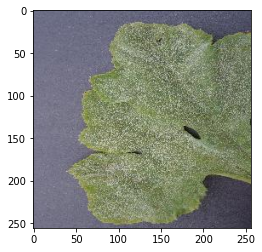

In [712]:
folderPath = "../../mildew/squash_powdery_mildew/"
imageNo = 20



image = cv2.cvtColor(cv2.imread(f'{folderPath}/{imageNo}.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(image)

<h1> Smoothen Image </h1>

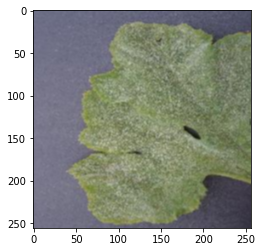

In [713]:
smooth = cv2.GaussianBlur(image, (3, 3), 1)

plt.imshow(smooth)

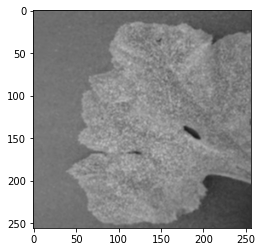

In [714]:
g = smooth[:, :, 1]

plt.imshow(g, cmap = 'gray', vmin = 0, vmax = 255)

<h3> Intensity histogram</h3>

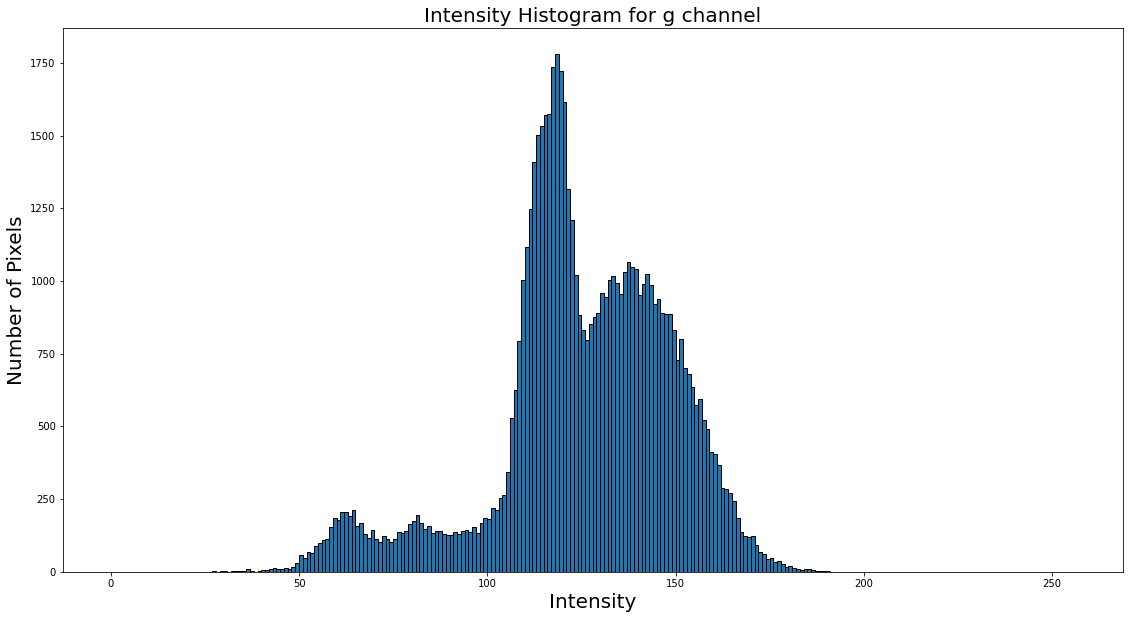

In [715]:
plt.figure(figsize = (19, 10))
plt.title("Intensity Histogram for g channel", fontsize = 20)
plt.xlabel("Intensity", fontsize = 20)
plt.ylabel("Number of Pixels", fontsize = 20)
histo,bins,_=plt.hist(g.flat, bins=256, range=(0, 256),ec='black')
plt.show()

<h2> Contrast Stretching </h2>

In [716]:
def stretch_contrast(image):
    '''
    Function to perform contrast stretching given an input image.
    
    Inputs =>
    image : numpy.ndarray representation of the image (must be only one channel)
    
    Returns =>
    con_image : min-max contrast stretched representation of the input image
    
    '''
    
    con_image = np.copy(image).reshape(-1)
    
    #min intensity
    min_i = np.amin(con_image)
    
    #max intensity
    max_i = np.amax(con_image)
    
    for idx, pixel in enumerate(con_image):
        
        con_image[idx] = 255 * ((pixel - min_i) / (max_i - min_i))
    
    #reshape and return
    con_image = con_image.reshape(image.shape)
    con_image = con_image.astype("uint8")
    
    return con_image
    

<h2> Extract leaf </h2> 

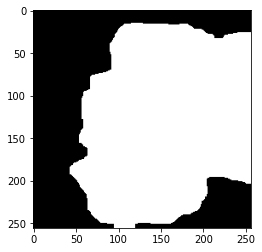

In [717]:
def extract_background(image):
    '''
    Perform k-means channel segmentation on the input mildew affected leaf.
    
    Inputs:
    image=> np.ndarray representation of the image. Background must be segmented
    mask=> mask for the leaf region on the image.
    
    returns:
    segment => segmentation result 
    '''
    im = image.copy()
    #convert to lab
    lab = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)

    #create a vector containing a*b* channel
    shape = lab.shape
    vector = lab[:, :, 1:]
    vector = vector.reshape(-1, 2)

    #convert to float32
    vector = np.float32(vector)

    #apply kmeans algorithm
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    K=3
    attempts=20
    _,label,center=cv2.kmeans(vector, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    #get centroids
    center = np.uint8(center)
    res = center[label.flatten()]

    resArr = []
    #convert into an image with constant luminance
    for ele in res:
        a,b = ele[0], ele[1]
        resArr.append([90, a, b])
        
    resArr = np.array(resArr, dtype = np.uint8).reshape(shape)

    #segment automatically based on min a* value
    a_channel = resArr[:,:,1]
    
    maxVal = np.amax(a_channel)

    resImg = []

    #loop and apply thresholding
    for ele1 in resArr.reshape(-1,3):

        a = ele1[1]

        if a == maxVal:
            resImg.append([0])

        else:
            resImg.append([255])
            

    resImg = np.array(resImg, dtype = np.uint8).reshape(image.shape[:2])
    opening = cv2.morphologyEx(resImg, cv2.MORPH_OPEN, kernel = np.ones((5, 5)), iterations = 2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel = np.ones((5, 5)), iterations = 2)
    cnts, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #fill contour for mask
    mask = np.ones(im.shape[:2], dtype="uint8") * 0
    mask = cv2.drawContours(mask, cnts, -1, (255), cv2.FILLED)
    return mask

mask = extract_background(image)

plt.imshow(mask, cmap = 'gray')

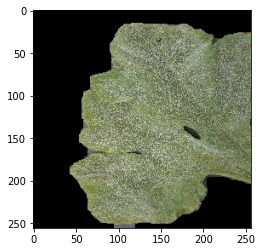

In [718]:
leaf = cv2.bitwise_and(image, image, mask = mask)
plt.imshow(leaf)

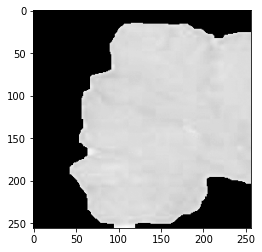

In [719]:
lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
lab = cv2.bitwise_and(lab, lab, mask = mask)
a = lab[:, :, 1]
plt.imshow(a, cmap = 'gray')

<h2> Contrast Stretching </h2>

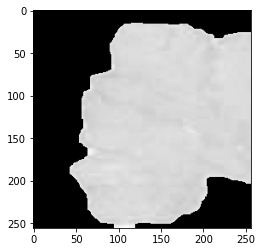

In [720]:
con_a = stretch_contrast(a)

plt.imshow(con_a, cmap = 'gray', vmin = 0 , vmax = 255)

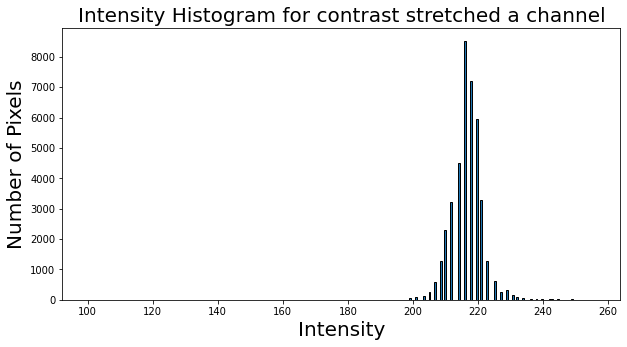

In [721]:
plt.figure(figsize = (10, 5))
plt.title("Intensity Histogram for contrast stretched a channel", fontsize = 20)
plt.xlabel("Intensity", fontsize = 20)
plt.ylabel("Number of Pixels", fontsize = 20)
histo,bins,_= plt.hist(con_a.flat, bins=256, range=(100, 256),ec='black')
plt.show()

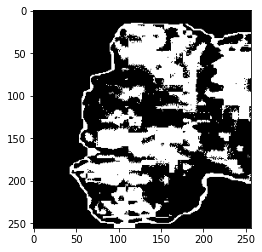

In [722]:
_, im = cv2.threshold(con_a, 217, 255, cv2.THRESH_BINARY)

plt.imshow(im, cmap = 'gray', vmin = 0, vmax = 255)

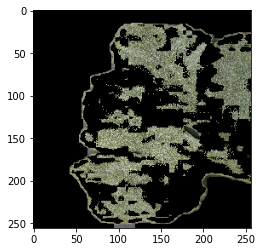

In [723]:
resImg = cv2.bitwise_and(image, image, mask = im)
plt.imshow(resImg)

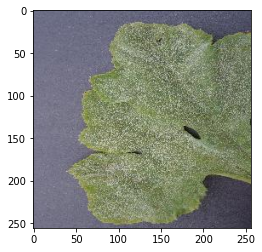

In [724]:
plt.imshow(image)

<h2> Using KMeans Clustering</h2>

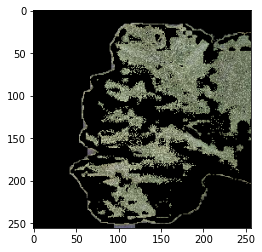

In [725]:
l,a,b=cv2.split(lab)

l,a,b=(l.flatten(),a.flatten(),b.flatten())
#create a vector containing a*b* channel
shape=lab.shape

vector=lab[:,:,1:]
vector=vector.reshape(-1,2)

#convert to float32
vector=np.float32(vector)

#criteria
criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,10,1.0)
K=3
attempts=10
ret,label,center=cv2.kmeans(vector,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)


center=np.uint8(center)
res=center[label.flatten()]

resArr=[]
for ele in res:
    a,b=ele[0],ele[1]
    resArr.append([90,a,b])
resArr=np.array(resArr,dtype=np.uint8)
resArr=resArr.reshape(shape)


a_channel=resArr[:,:,1]
b_channel=resArr[:,:,2]
plt.imshow(a_channel,cmap="gray")

maxVal=np.amax(a_channel)

resImg=[]


for ele1,ele2 in zip(resArr.reshape(-1,3),leaf.reshape(-1,3)):
    
    a = ele1[1]
    
    if a == maxVal:
        resImg.append([ele2[0],ele2[1],ele2[2]])
    
    else:
        resImg.append([0, 0, 0])

resImg = np.array(resImg, dtype = np.uint8)  
resImg = resImg.reshape(lab.shape)

plt.imshow(resImg[:, :, 1], cmap = 'gray')

res, th2 = cv2.threshold(resImg[:, :, 1], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

resImg = cv2.bitwise_and(image, image, mask = th2)

plt.imshow(resImg)

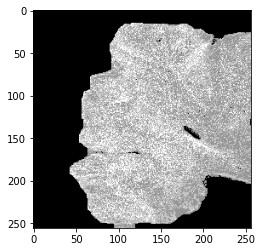

In [726]:
shape=leaf.shape

vector=leaf[:,:,0:]
vector=vector.reshape(-1,3)

#convert to float32
vector=np.float32(vector)

#criteria
criteria=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,10,1.0)
K=4
attempts=10
ret,label,center=cv2.kmeans(vector,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)


center=np.uint8(center)
res=center[label.flatten()]

resArr=[]
for ele in res:
    r,g, b=ele[0],ele[1], ele[2]
    resArr.append([r,g,b])
resArr=np.array(resArr,dtype=np.uint8)
resArr=resArr.reshape(shape)

gray = cv2.cvtColor(resArr, cv2.COLOR_RGB2GRAY)

plt.imshow(gray, cmap = 'gray')

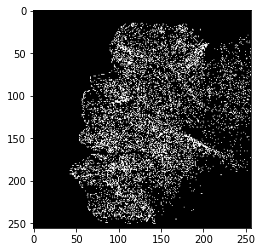

In [727]:
maxi = np.amax(gray)

resImg = []

for pix in gray.reshape(-1):
    if pix == maxi:
        resImg.append([255])
    else:
        resImg.append([0])
resImg = np.array(resImg, dtype = np.uint8).reshape(gray.shape)
plt.imshow(resImg, cmap = 'gray')



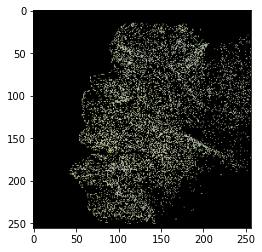

In [728]:
res = cv2.bitwise_and(image, image, mask = resImg)
plt.imshow(res)

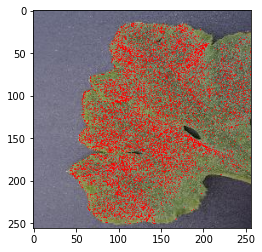

In [729]:
im_s = []
for  pixel1, pixel2 in zip(resImg.reshape(-1), image.reshape(-1, 3)):
    if pixel1 == 255:
        im_s.append([255, 0, 0])
    else:
        im_s.append(pixel2)
        
im_s = np.array(im_s, dtype = np.uint8).reshape(image.shape)
        
plt.imshow(im_s)

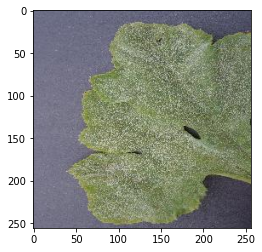

In [730]:
plt.imshow(image)